In [1]:
import numpy as np
import networkx as nx
from dwdynamics import ComplexDynamicsProblem, Objective,helpers ,instance# Difference a. We are using ComplexDynamicsProblem
import matplotlib.pyplot as plt
import json
import os
from dwave_networkx.generators.pegasus import (get_tuple_defragmentation_fn, fragmented_edges,
    pegasus_coordinates, pegasus_graph)
from dwave.system import DWaveSampler, EmbeddingComposite
import matplotlib.pyplot as plt
from collections import defaultdict
import re
from tqdm import tqdm
import scipy 
import pickle as pckl

In [2]:
import sys
print(sys.path[1])

/usr/lib/python311.zip


In [3]:
import os
import re
import pandas as pd
import numpy as np
import math
import dimod.sampleset


# List instances

In [ ]:
path = f'../data/instances/'
for item in os.listdir(path):
    if item[-5:] == '.pckl':    
        with open(os.path.join(path, item),'rb') as f:
            print(f"---------- System {item[0]} ------------")
            print(pckl.load(f)['about'])

---------- System 2 ------------
np.pi*1/math.sqrt(2)(X+Z)
---------- System 6 ------------
np.pi/2*|000><111|+|111><000|
---------- System 3 ------------
PT Symmetric from |0>
---------- System 4 ------------
maximally entangled qubit
---------- System 5 ------------
|00><11|+|00><11|
---------- System 8 ------------
sigma_y
---------- System 1 ------------
0.5PI * SY
---------- System 7 ------------
np.pi*helpers.generate_pt_symmetric_real_eig(0.5)
---------- System 9 ------------
(np.pi/2)*helpers.generate_pt_symmetric_real_eig(0.5)


# Analyze

In [5]:
def load_data(pruned = True, raw = False,topology='6.4',system=1):
    if pruned:
        path = f'../data/results/pruned/{system}/'

    else:
        path = f'../data/results/notpruned/{system}/'
    dfs = []
    for topology in [topology]:
        path += topology
        for file in os.listdir(path):
            precision = int(re.findall('(?<=precision_)\d+',file)[0])
            timepoints = int(re.findall('(?<=timepoints_)\d+',file)[0])
            with open(os.path.join(path,file),'r') as f:
                s = dimod.SampleSet.from_serializable(json.load(f))
        
            qpu_access_time = s.info['timing']['qpu_access_time']
            s = s.to_pandas_dataframe()
            if not raw:
                s = s[['energy','num_occurrences']]
            s['systemid'] = topology
            s['precision'] = precision
            s['timepoints'] = timepoints
            s['energy'] = abs(round(s['energy'],10))
            s['access_time'] = (qpu_access_time / s['num_occurrences'].sum()) * s['num_occurrences'] * 1e-3
            dfs.append(s)

    dfs_all = pd.concat(dfs)

    return dfs_all

def get_precision_timepoints_pairs(dfs):
    dfs = dfs.groupby(['precision','timepoints'])['num_occurrences'].count()
    return list(set(dfs.index))

In [6]:
topology='5.4'
dfs_all = load_data(pruned = True,topology=topology,system=4)
dfs_all_rounded = dfs_all.copy()
dfs_all_rounded['energy'] = dfs_all_rounded['energy'].apply(lambda x: math.ceil(x)) # for displaying in a histogram


In [7]:
dfs_grouped =dfs_all.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum() 
dfs_grouped_rounded = dfs_all_rounded.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum()
dfs_keys = set([(key[0],key[1],key[2]) for key in dfs_grouped.keys()])
for key in dfs_keys:
    dfs_grouped[key] = dfs_grouped[key] / dfs_grouped[key].sum() * 100
    dfs_grouped_rounded[key] = dfs_grouped_rounded[key] / dfs_grouped_rounded[key].sum() * 100

dfs_grouped_rounded 

/tmp/ipykernel_37168/4200412015.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.200e-01 1.020e+00 4.020e+00 9.700e+00 1.676e+01 2.052e+01 1.826e+01
 1.398e+01 8.180e+00 3.420e+00 1.980e+00 1.060e+00 4.400e-01 3.200e-01
 4.000e-02 8.000e-02 2.000e-02 6.000e-02 2.000e-02]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfs_grouped[key] = dfs_grouped[key] / dfs_grouped[key].sum() * 100
/tmp/ipykernel_37168/4200412015.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.200e-01 1.020e+00 4.020e+00 9.700e+00 1.676e+01 2.052e+01 1.826e+01
 1.398e+01 8.180e+00 3.420e+00 1.980e+00 1.060e+00 4.400e-01 3.200e-01
 4.000e-02 8.000e-02 2.000e-02 6.000e-02 2.000e-02]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfs_grouped_rounded[key] = dfs_

systemid  precision  timepoints  energy
5.4       2          2           0          0.12
                                 1          1.02
                                 2          4.02
                                 3          9.70
                                 4         16.76
                                 5         20.52
                                 6         18.26
                                 7         13.98
                                 8          8.18
                                 9          3.42
                                 10         1.98
                                 11         1.06
                                 12         0.44
                                 13         0.32
                                 14         0.04
                                 15         0.08
                                 16         0.02
                                 18         0.06
                                 19         0.02
Name: num_occurrences, dtype:

defaultdict(<class 'list'>, {2: [2]})
prec 2 timepoints 2
   energy  num_occurrences
0       0             0.12
1       1             1.02
2       2             4.02
3       3             9.70
4       4            16.76


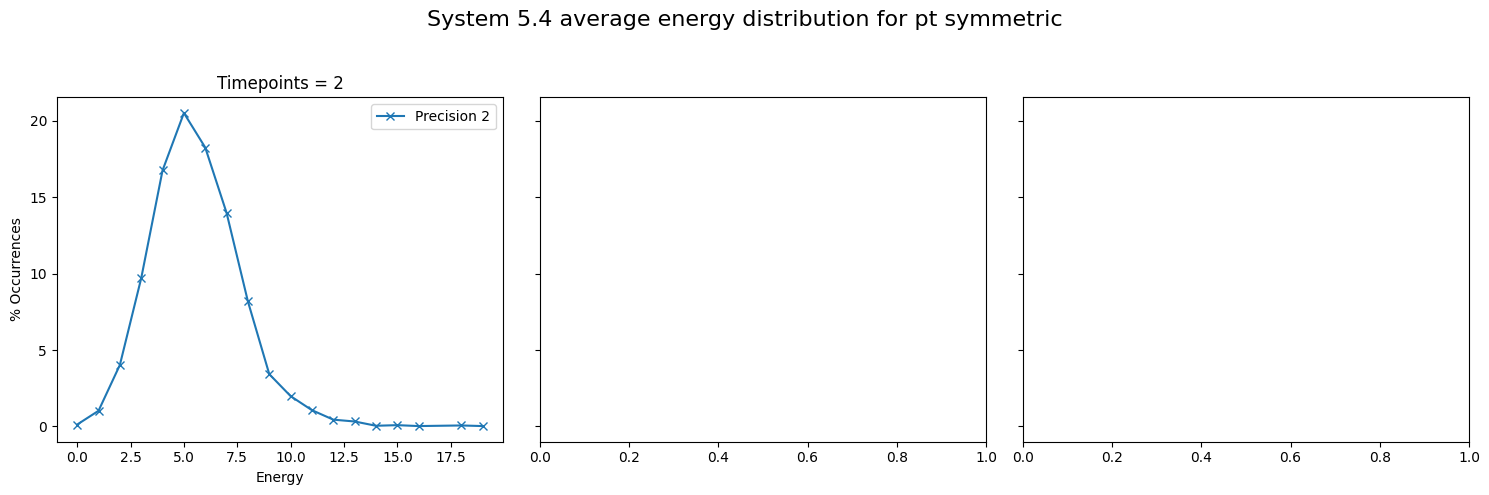

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle(f"System {topology} average energy distribution for pt symmetric", fontsize=16)
markers = ['x','o','v']
prec_time_pairs = get_precision_timepoints_pairs(dfs_all)
timepoint_dict = defaultdict(list)
for timepoint_par in prec_time_pairs:
    timepoint_dict[timepoint_par[1]].append(timepoint_par[0])

print(timepoint_dict)
timepoints = sorted(timepoint_dict.keys())
for i, timepoint in enumerate(timepoints):
    ax = axes[i]
    for p in sorted(timepoint_dict[timepoint]):
        df = dfs_grouped_rounded[topology, p, timepoint].reset_index()
        print(f"prec {p} timepoints {timepoint}")
        print(df.head(5))
        ax.plot(df['energy'], df['num_occurrences'], label=f"Precision {p}", marker=markers[p-2])

    ax.set_xlabel('Energy')
    ax.set_title(f"Timepoints = {timepoint}")
    #ax.set_xlim(0, 200)
    if i == 0:
        ax.set_ylabel('% Occurrences')
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
#plt.savefig('../plots/system54_energy_distribution.pdf')
plt.show()

# Interpret results

-------
np.pi*helpers.generate_pt_symmetric_real_eig(0.5)
---------
---------
array([[-1.+0.00000000e+00j,  0.+6.57201340e-16j],
       [ 0.+7.77156117e-16j, -1.+0.00000000e+00j]])
------
array([[ 2.+0.00000000e+00j,  0.+0.00000000e+00j,  1.+0.00000000e+00j,
        -0.+7.77156117e-16j],
       [ 0.+0.00000000e+00j,  2.+0.00000000e+00j, -0.+6.57201340e-16j,
         1.+0.00000000e+00j],
       [ 1.-0.00000000e+00j, -0.-6.57201340e-16j,  1.+0.00000000e+00j,
         0.+0.00000000e+00j],
       [-0.-7.77156117e-16j,  1.-0.00000000e+00j,  0.+0.00000000e+00j,
         1.+0.00000000e+00j]])
-------
np.pi*helpers.generate_pt_symmetric_real_eig(0.5)
---------
---------
array([[-1.+0.00000000e+00j,  0.+6.57201340e-16j],
       [ 0.+7.77156117e-16j, -1.+0.00000000e+00j]])
------
---------
array([[-1.+0.00000000e+00j,  0.+6.57201340e-16j],
       [ 0.+7.77156117e-16j, -1.+0.00000000e+00j]])
------
array([[ 2.+0.00000000e+00j,  0.+0.00000000e+00j,  1.+0.00000000e+00j,
        -0.+7.77156117e-16j,

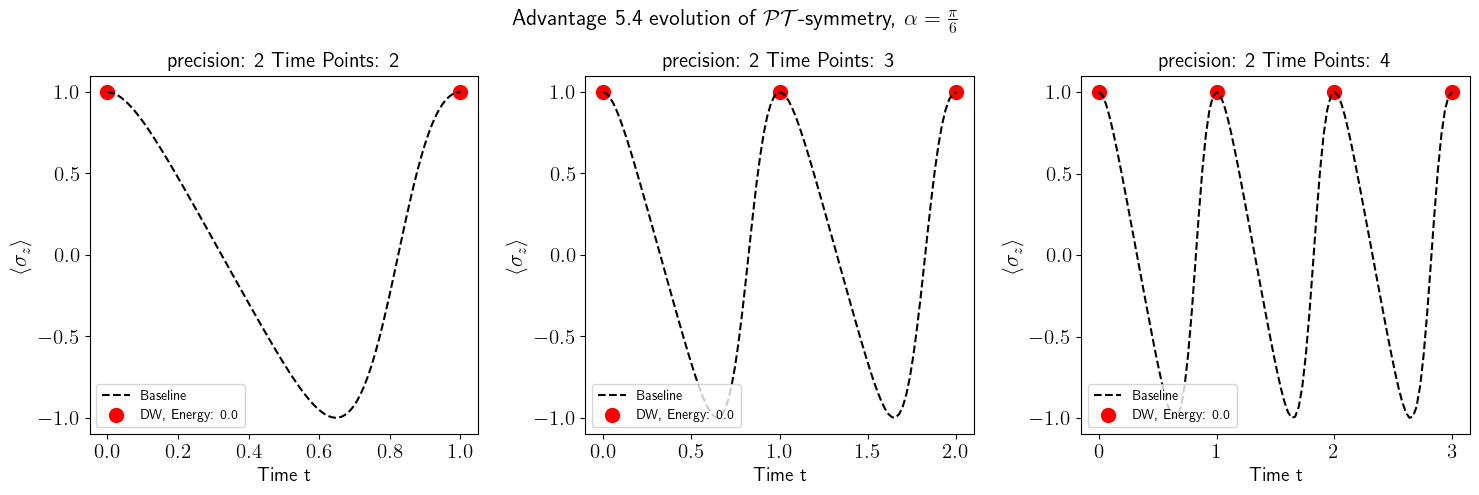

In [9]:
import qutip as qp

system = 7

plt.rcParams['text.usetex'] = True
dfs_data_raw = load_data(raw=True,topology=topology,system=system)
tp_pairs = get_precision_timepoints_pairs(dfs_data_raw)
tp_pairs.sort(key=lambda x: x[0]*10 + x[1])
dfs_data_raw['systemid']

# Loop over all rows in velox_results and plot all dynamics on the same panel,
# coloring each curve according to its best_energy.
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ["o", "s", "^", "D", "v", "<", ">"]

SY = np.array([[0, -1.0j], [1.0j, 0.0]])
SZ = np.array([[1, 0], [0, -1]])


plot_rows =  1
plot_columns = 3
# Create a single axis for the plot
fig, axes = plt.subplots(plot_rows, plot_columns, figsize=(5*plot_columns, 5*plot_rows), sharey=False)
axes = axes.flatten()

system_latex_dict = {
    1: 'H = $\frac{\pi}{2}\sigma_y$',
    3: 'one qubit pt symmetric system (seed=1)',
    4: 'maximally entangled 2 qubit system',
    7: '$\mathcal{P}\mathcal{T}$-symmetry, $\\alpha=\\frac{\\pi}{6}$'
}




for i, (precision,timepoints) in enumerate(tp_pairs):
    instance_dict = helpers.get_instance(system)
    H = instance_dict['H']
    PSI0 = instance_dict['psi0']


    #baseline 
    dim = int(math.log(len(H),2))




    psi_0 = qp.tensor([qp.basis(2, 0)]*dim)


    #psi_0 = PSI0
    times = np.linspace(0, timepoints-1, 100)
    baseline = qp.mesolve(qp.Qobj(H), psi_0, times, e_ops=[qp.sigmaz()]).expect
    ax = axes[i]

    ax.plot(times, baseline[0], "k--",label="Baseline")


    problem = ComplexDynamicsProblem(
        hamiltonian=H,      # Evolution under hamiltonian 0.5 * np.pi * sigma_y
        initial_state = PSI0,              # Starting at initial state |0>,
        times=tuple(range(timepoints)),             # With six time points 0,1,2
        num_bits_per_var=precision               # And two bits of precision per variable
    )

    dfs_filtered = dfs_data_raw[(dfs_data_raw.precision == precision) & (dfs_data_raw.timepoints == timepoints)]
    dfs_filtered = dfs_filtered.drop(['num_occurrences'],axis=1)
    dfs_filtered.drop_duplicates(inplace=True)
    dfs_filtered = dfs_filtered.sort_values(by='energy').head(1)
    dfs_filtered = dfs_filtered.sort_values(by='energy',ascending=False)
    energies = list(dfs_filtered['energy'])
    dfs_filtered = dfs_filtered.filter(regex='\d+')
    dfs_filtered = dfs_filtered.apply(pd.to_numeric)
    for j, (_, row) in enumerate(dfs_filtered.iterrows()): 
        sol_dict = row.dropna().to_dict()
        sol_dict = {key:int(value) for key,value in sol_dict.items()}

        vec =problem.interpret_sample(sol_dict)
        dw_expect = [(state.conj() @ SZ @ state).real for state in vec]

        ax.scatter(problem.times, dw_expect, color=colors[j % len(colors)], marker=markers[j % len(markers)], label=f"DW, Energy: {abs(round(energies[j],4))}", alpha=1.0, s=100)

        #ax.plot(problem.times, expect, color=colors[j % len(colors)], alpha=0.5, linewidth=0.1)
    ax.set_xlabel("Time t", fontsize=14)
    ax.set_ylabel(r"$\langle \sigma_z \rangle$", fontsize=16)
    ax.set_title(f"precision: {problem.num_bits_per_var} Time Points: {len(problem.times)}",fontsize=15)


    ax.legend(loc='lower left')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=13)

fig.suptitle(f"Advantage {topology} " +rf"evolution of {system_latex_dict[system]} ",fontsize=16)
plt.tight_layout()
plt.savefig(f'../plots/solver_{topology}_dynamic_{system}.pdf')
plt.show()



-------
|00><11|+|00><11|
---------
-------
|00><11|+|00><11|
---------
-------
|00><11|+|00><11|
---------


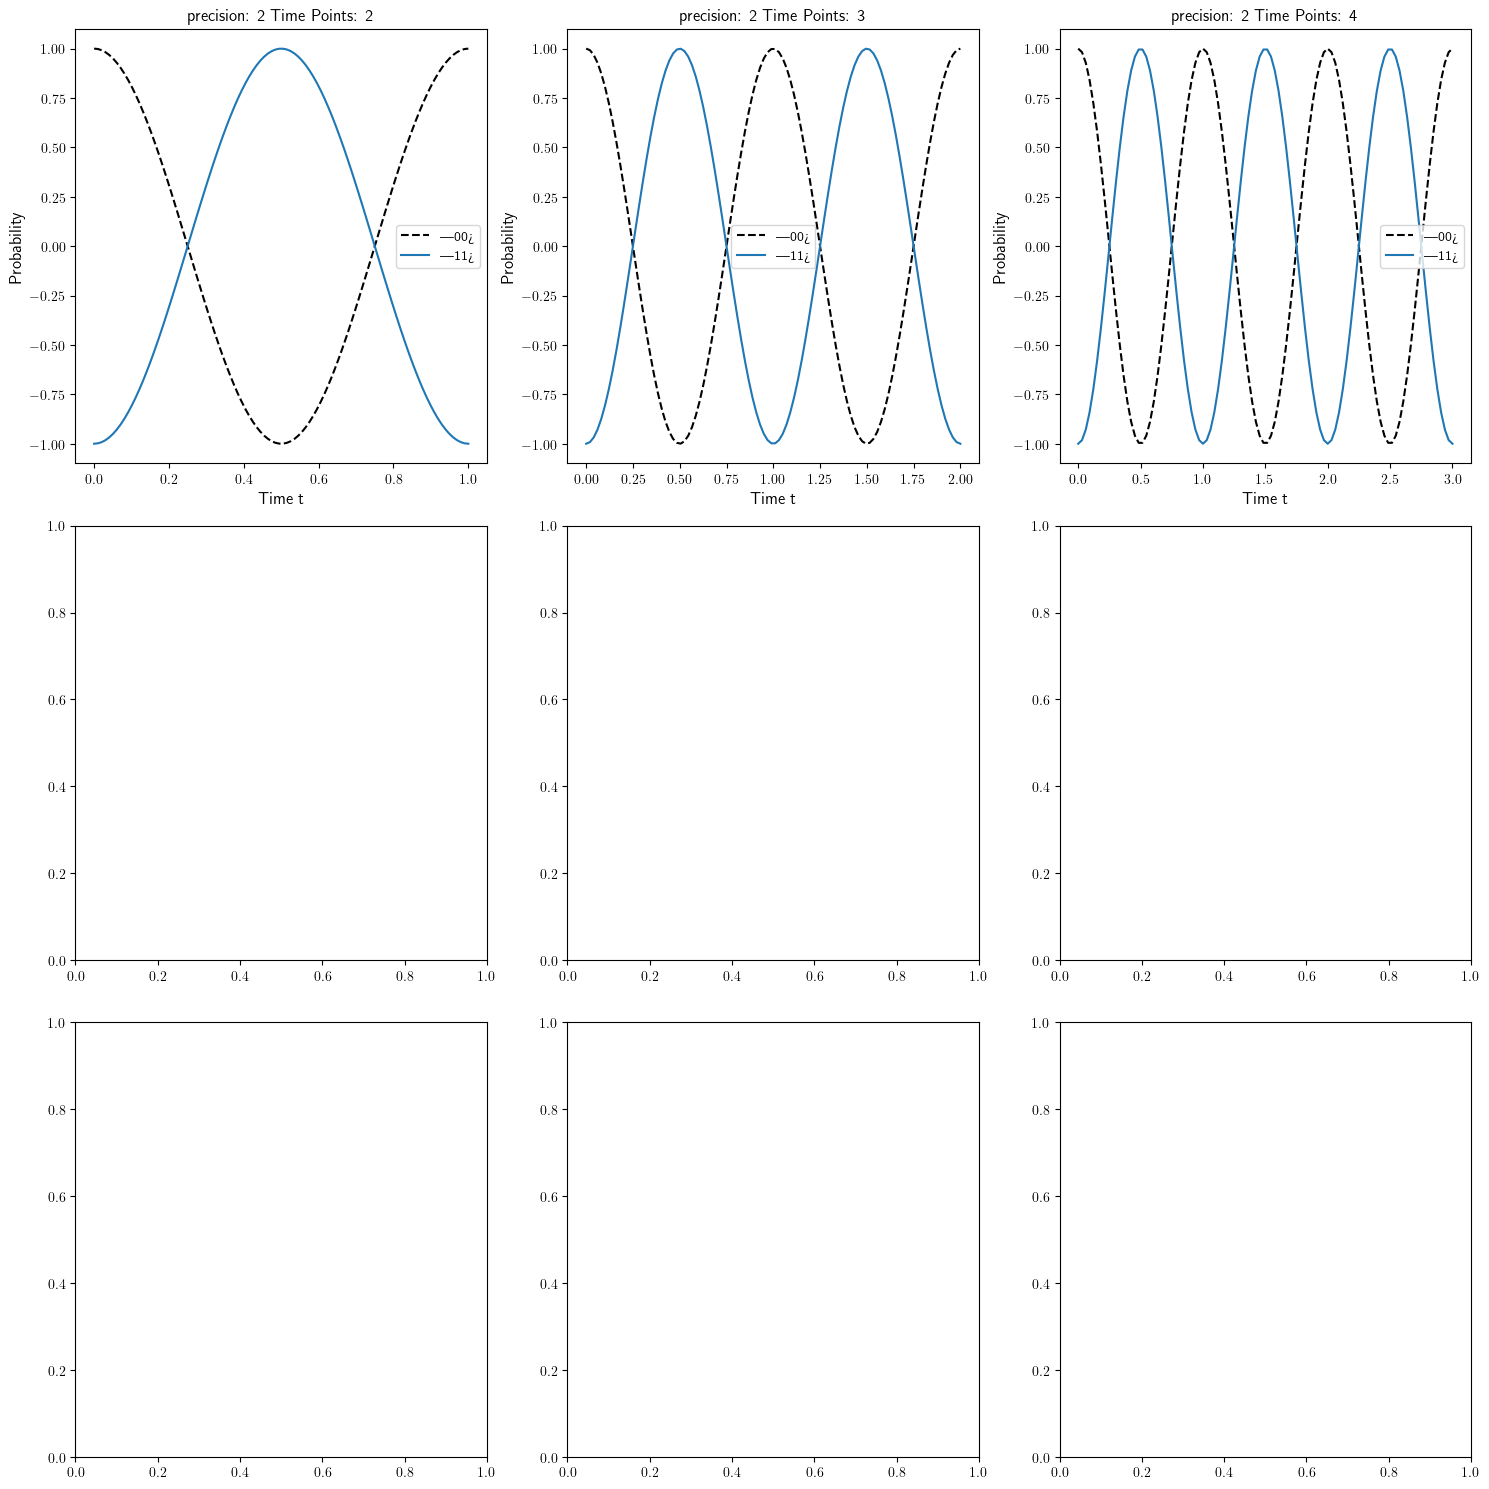

In [10]:
import qutip as qp

system = 5

dfs_data_raw = load_data(raw=True,topology=topology,system=system)
tp_pairs = get_precision_timepoints_pairs(dfs_data_raw)
tp_pairs.sort(key=lambda x: x[0]*10 + x[1])
dfs_data_raw['systemid']
# We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...

# Loop over all rows in velox_results and plot all dynamics on the same panel,
# coloring each curve according to its best_energy.
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ["o", "s", "^", "D", "v", "<", ">"]

SY = np.array([[0, -1.0j], [1.0j, 0.0]])
PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.


# Create a single axis for the plot
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=False)
axes = axes.flatten()

system_latex_dict = {
    1: 'H = $\frac{\pi}{2}\sigma_y$',
    3: 'one qubit pt symmetric system (seed=1)',
    4: 'maximally entangled 2 qubit system'
}




for i, (precision,timepoints) in enumerate(tp_pairs):
    instance_dict = helpers.get_instance(system)

    ket01 = qp.tensor(qp.basis(2, 0), qp.basis(2, 1))
    ket10 = qp.tensor(qp.basis(2, 1), qp.basis(2, 0))

    # Operator H = |01><10| + |10><01|
    H_qp = np.pi*(ket01 * ket10.dag() + ket10 * ket01.dag())
    #H = instance['H']

    #baseline 
   # dim = int(math.log(len(H),2))
    dim=2
    # Projectors on |0..0⟩ and |1..1⟩
    P_00 = qp.tensor([qp.basis(2, 0)]*dim).proj()
    P_11 = qp.tensor([qp.basis(2, 1)]*dim).proj()

    #H_qp = qp.Qobj(H,dims=[[2]*dim,[2]*dim])

    psi_0 = qp.tensor([qp.basis(2, 1)]*dim)

    psi_0 = qp.tensor(qp.basis(2, 0), qp.basis(2, 1))
    times = np.linspace(0, timepoints-1, 100)
    baseline = qp.mesolve(H_qp, psi_0, times, e_ops=[qp.tensor(qp.sigmaz(),qp.qeye(2)),qp.tensor(qp.qeye(2),qp.sigmaz())]).expect
    ax = axes[i]

    ax.plot(times, baseline[0], "k--",label="|00>")
    ax.plot(times, baseline[1],label="|11>")


    problem = ComplexDynamicsProblem(
        hamiltonian=H,      # Evolution under hamiltonian 0.5 * np.pi * sigma_y
        initial_state = PSI0,              # Starting at initial state |0>,
        times=tuple(range(timepoints)),             # With six time points 0,1,2
        num_bits_per_var=precision               # And two bits of precision per variable
    )

    dfs_filtered = dfs_data_raw[(dfs_data_raw.precision == precision) & (dfs_data_raw.timepoints == timepoints)]
    dfs_filtered = dfs_filtered.drop(['num_occurrences'],axis=1)
    dfs_filtered.drop_duplicates(inplace=True)
    dfs_filtered = dfs_filtered.sort_values(by='energy').head(1)
    dfs_filtered = dfs_filtered.sort_values(by='energy',ascending=False)
    energies = list(dfs_filtered['energy'])
    dfs_filtered = dfs_filtered.filter(regex='\d+')
    dfs_filtered = dfs_filtered.apply(pd.to_numeric)
    for j, (_, row) in enumerate(dfs_filtered.iterrows()): 
        sol_dict = row.dropna().to_dict()
        sol_dict = {key:int(value) for key,value in sol_dict.items()}

        #vec =problem.interpret_sample(sol_dict)

        #expect_00 = [(state.conj() @ P_00.full() @ state).real for state in vec]
        #expect_11 = [(state.conj() @ P_11.full() @ state).real for state in vec]

        #ax.scatter(problem.times, expect_00, color=colors[j % len(colors)], marker=markers[j % len(markers)], label=f"|00> Energy: {round(energies[j],4)}", alpha=1.0, s=100)
        #ax.scatter(problem.times, expect_11, color='black', marker=markers[j % len(markers)],label=f"|11> Energy: {round(energies[j],4)}", alpha=1.0, s=100)

        #ax.plot(problem.times, expect, color=colors[j % len(colors)], alpha=0.5, linewidth=0.1)
    ax.set_xlabel("Time t", fontsize=12)
    ax.set_ylabel(r"Probability", fontsize=12)
    ax.set_title(f"precision: {problem.num_bits_per_var} Time Points: {len(problem.times)}")


    ax.legend()
#fig.suptitle(f"Advantage {topology} " +rf"evolution of {system_latex_dict[system]} ",fontsize=16)
plt.tight_layout()
#plt.savefig(f'../plots/system{topology}_dynamic_{system}.pdf')
plt.show()



# Performance comparison Velox vs D-Wave

   index  precision  timepoints  num_steps  num_var   runtime  num_rep  \
4      0          2           2        NaN     16.0  0.302573      NaN   
5      1          2           3        NaN     24.0  0.305203      NaN   
6      2          2           4        NaN     32.0  0.306972      NaN   
7      3          2           5        NaN     40.0  0.312101      NaN   

   success_prob source topology  system x_label        tts99  
4      0.022985  DWAVE      6.4       7    2\n2    59.923164  
5      0.007448  DWAVE      6.4       7    2\n3   188.012640  
6      0.001268  DWAVE      6.4       7    2\n4  1113.907899  
7      0.000000  DWAVE      6.4       7    2\n5          inf  


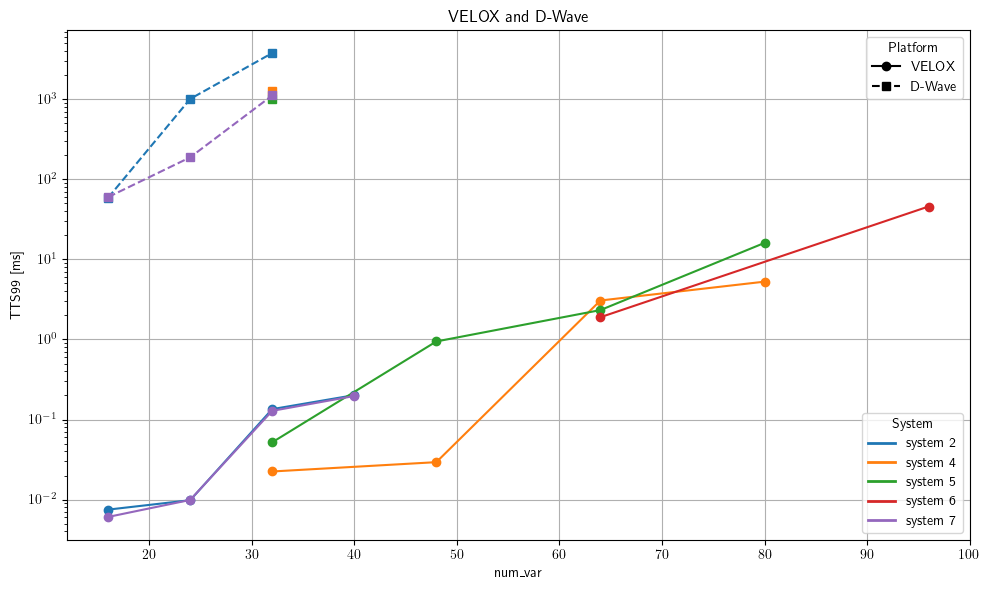

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.tab10.colors  # do 10 systemów
systems = [2, 4, 5, 6, 7]
from matplotlib.lines import Line2D
for idx, system in enumerate(systems):
    df1_filtered = helpers.get_velox_success_rates(system)
    df2_filtered = helpers.get_dwave_success_rates(system=system)

    # Dodajemy identyfikator źródła
    df1_filtered['source'] = 'VELOX'
    df2_filtered['source'] = 'DWAVE'

    # Łączymy oba DataFrame'y
    combined = pd.concat([df1_filtered,df2_filtered])
    # Reset indeksu do kolumn
    combined = combined.reset_index()
    # Tworzymy etykiety X
    combined['system'] = system
    combined['x_label'] = combined['precision'].astype(str) + '\n' + combined['timepoints'].astype(str)
    combined['tts99'] = combined.apply(lambda row: helpers.return_tts(row['success_prob'],row.runtime),axis=1)
    #print(combined[['system','num_var','precision','timepoints','source','runtime','success_prob','tts99']].to_latex(escape=True))
    df = combined.copy()
    

    velox = df[df['source'] == 'VELOX'].dropna(subset=['num_var', 'tts99'])
    dwave = df[df['source'] == 'DWAVE'].dropna(subset=['num_var', 'tts99'])
    if system == 7:
        print(dwave)
    color = colors[idx % len(colors)]
    
    ax.plot(velox['num_var'], velox['tts99'],
            marker='o', linestyle='-', color=color, label=f'system {system}')
    
    ax.plot(dwave['num_var'], dwave['tts99'],
            marker='s', linestyle='--', color=color)

# Legenda 1: styl/metoda
style_legend = [
    Line2D([0], [0], color='black', linestyle='-', marker='o', label='VELOX'),
    Line2D([0], [0], color='black', linestyle='--', marker='s', label='D-Wave')
]

legend1 = ax.legend(handles=style_legend, title='Platform', loc='upper right')

# Legenda 2: kolory/systemy
color_legend = [
    Line2D([0], [0], color=colors[idx % len(colors)], lw=2, label=f'system {s}') for idx, s in enumerate(systems)
]

legend2 = ax.legend(handles=color_legend, title='System', loc='lower right')
ax.add_artist(legend1)  # dodaj pierwszą legendę z powrotem do osi

# Oś, tytuł itd.
ax.set_xlabel('num_var')
ax.set_ylabel('TTS99 [ms]')
ax.set_yscale('log')
ax.grid(True)
ax.set_title('VELOX and D-Wave')
plt.tight_layout()
plt.show()


   index  precision  timepoints  num_steps       runtime   num_rep  \
0      0          2           2     1000.0  1.530215e-05  524280.0   
1      1          2           3     1000.0  8.644441e-07  524280.0   
2      2          2           4     1000.0  9.160250e-07  524280.0   
3      3          2           5     1000.0  1.043662e-06  524280.0   
4      0          2           2        NaN  3.043558e-01       NaN   
5      1          2           3        NaN  3.010032e-01       NaN   
6      2          2           4        NaN  3.194976e-01       NaN   
7      3          2           5        NaN  3.077667e-01       NaN   

   success_prob source topology  
0      0.297498    DF1      NaN  
1      0.195672    DF1      NaN  
2      0.017296    DF1      NaN  
3      0.011255    DF1      NaN  
4      0.023530    DF2      6.4  
5      0.001373    DF2      6.4  
6      0.000390    DF2      6.4  
7      0.000000    DF2      6.4  


,index,precision,timepoints,num_steps,runtime,num_rep,success_prob,source,topology,x_label,tts99
0,0,2,2,1000.0,1.530215e-05,524280.0,0.297498,DF1,NaN,2\n2,0.000200
1,1,2,3,1000.0,8.644441e-07,524280.0,0.195672,DF1,NaN,2\n3,0.000018
2,2,2,4,1000.0,9.160250e-07,524280.0,0.017296,DF1,NaN,2\n4,0.000242
3,3,2,5,1000.0,1.043662e-06,524280.0,0.011255,DF1,NaN,2\n5,0.000425
4,0,2,2,NaN,3.043558e-01,NaN,0.023530,DF2,6.4,2\n2,58.862593
5,1,2,3,NaN,3.010032e-01,NaN,0.001373,DF2,6.4,2\n3,1008.800732
6,2,2,4,NaN,3.194976e-01,NaN,0.000390,DF2,6.4,2\n4,3769.574781
7,3,2,5,NaN,3.077667e-01,NaN,0.000000,DF2,6.4,2\n5,inf


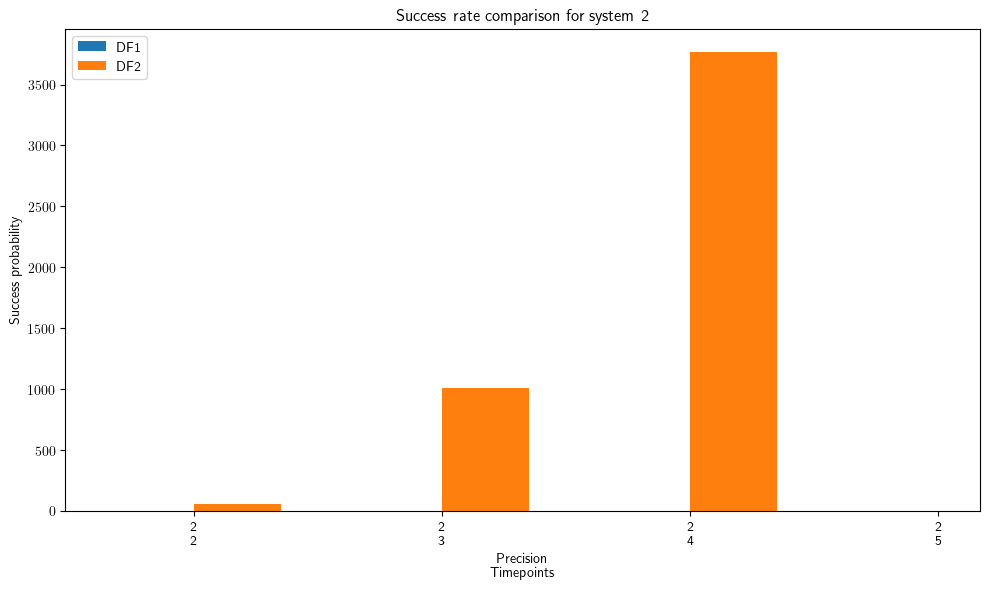

In [30]:
# Ustawienia wykresu
fig, ax = plt.subplots(figsize=(10, 6))

# Rysujemy słupki
sources = combined['source'].unique()
x_labels = combined['x_label'].unique()
x = range(len(x_labels))
bar_width = 0.35

for i, source in enumerate(sources):
    subset = combined[combined['source'] == source]
    offset = [xi + i * bar_width for xi in x]
    ax.bar(offset, subset['tts99'], width=bar_width, label=source)

# Oś X
ax.set_xticks([xi + bar_width / 2 for xi in x])
ax.set_xticklabels(x_labels)
ax.set_xlabel('Precision\nTimepoints')
ax.set_ylabel('Success probability')
ax.set_title(f'Success rate comparison for system {system}')
ax.legend()

plt.tight_layout()
plt.show()